In [55]:
import sys
import json
import pandas as pd
import numpy as np
sys.path.append("..")

from src.utils_methods import encode, get_var_metadata, post_process, transform_df_to_json, generate_plots, check_constraints
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import json
import os
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import hstack
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from catboost import CatBoostRegressor
import copy
import matplotlib.pyplot as plt
from npeet import entropy_estimators as ee

In [56]:
def reshape_get_mean(arr):
    original_shape = arr.shape
    new_shape = (original_shape[0], original_shape[1]*original_shape[2], *original_shape[3:])
    result = arr.reshape(new_shape)
    average = np.mean(result, axis=1)
    std = np.std(result, axis=1)
    return average, std

def get_real_synth_means(outputs):
    re = outputs[:,:,:1, :, :]
    sy = outputs[:,:,1:, :, :]
    re_av, re_std = reshape_get_mean(re)
    sy_av, sy_std = reshape_get_mean(sy)
    return re_av, re_std, sy_av, sy_std


def discrete_entropy(instances, discrete_columns):
    discrete_only = instances[:, discrete_columns]
    de = ee.entropyd(discrete_only)
    return de
def continuous_entropy(instances, continuous_columns):
    continuous_only = instances[:, continuous_columns]
    ce = ee.entropy(continuous_only)
    return ce

def get_metrics(metrics, instances):   
    table = {}
    # Populate the table with metric values
    for metric_name, metric in metrics.items():
        table[metric_name] = metric(instances)
    return table

In [57]:
import json
with open("compare_ga_plausibility_not_famd.json") as f:
    outputs = json.load(f)

In [58]:
ga_folders = list(outputs.keys())

print(len(outputs[ga_folders[0]]["average_list"]))
thr_labels = []
z_scores = []

17


In [59]:
baseline = [0, 0.25, 0.5, 0.75]
std = [1,2]
z_scores = baseline 
for stdd in std:
    z_scores += [stdd+x for x in baseline]
z_scores.append("inf")
print(z_scores)

[0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 'inf']


In [60]:
from matplotlib.colors import LinearSegmentedColormap

# Define the colormap
def create_colormap(alpha_min, alpha_max, alphas, num_segments=256):
    # Create a list of alpha values with a linear gradient
    num_segments = len(alphas)
    alphas = np.linspace(alpha_min, alpha_max, num_segments)

    # Create a colormap using the alpha values
    colors = [(0, 0, 0, alpha) for alpha in alphas]
    cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=num_segments)

    return cmap

In [61]:
better_names = {"RF":"Random\n Forest", "DT":"Decission\n Tree",
 "CBR": "CatBoost", "vae":"VAE", "llm":"LLM", "dgmm":"MDGMM",
  "DE":"Discrete Entropy", "DiffE": "Continuous Entropy",
  # "ga_results_FAMD Mahalanobis": "Mahalanobis (FAMD)",
  # "ga_results_famd one class svm_nu_0.5": "One Class-SVM (FAMD)",
  "ga_results_one class svm_nu_0.5": "One-class SVM",
  "ga_results_one class svm_nu_0.5_synthetic": "One-class SVM (Synthetic)",
  "ga_results_one class svm_nu_0.5_synthetic_10k": "One class-SVM (Synthetic 10k)",
  "one_class_svm_nu_0.25": "One class-SVM (nu=0.25)",
  "one_class_svm_nu_0.75": "One class-SVM (nu=0.75)",
  "one_class_svm_nu_0.9": "One class-SVM (nu=0.9)",
  # "ga_results_FAMD_GMM": "GMM (FAMD)",
  "KDE": "KDE",
  'local outlier factor': "Local Outlier Factor",
  "isolation_forest": "Isolation Forest",
  "isolation_forest_augmented": "Isolation Forest (Concatenated)",
  "isolation_forest_synthetic": "Isolation Forest (Synthetic)",
  "isolation_forest_synthetic_10k": "Isolation Forest (Synthetic 10k)",
  "KDE_augmented": "KDE (Concatenated)",
  "KDE_synthetic": "KDE (Synthetic)",
  "KDE_synthetic_10k": "KDE (Synthetic 10k)",
  "ga_results_one class svm_nu_0.5_augmented": "One Class-SVM (Concatenated)",
  }
markers = {
  # "ga_results_FAMD Mahalanobis": "x",
  # "ga_results_famd one class svm_nu_0.5": "^",
  # "ga_results_FAMD_GMM": "*",
  # 'local outlier factor':"p",

  "one_class_svm_nu_0.25": "o",
  "one_class_svm_nu_0.75": "o",
  "one_class_svm_nu_0.9": "o",
  "ga_results_one class svm_nu_0.5": "o",
  "ga_results_one class svm_nu_0.5_synthetic": "o",
  "ga_results_one class svm_nu_0.5_synthetic_10k": "o",
  "ga_results_one class svm_nu_0.5_augmented": "o",

  "KDE": "x",
  "KDE_augmented": "x",
  "KDE_synthetic": "x",
  "KDE_synthetic_10k": "x",

  "isolation_forest_augmented": "s",
  "isolation_forest": "s",
  "isolation_forest_synthetic": "s",
  "isolation_forest_synthetic_10k": "s",
}
model_names = ["CBR", "DT", "RF"]
keysm = ["DE", "DiffE"]
metric_names=["MSE"]


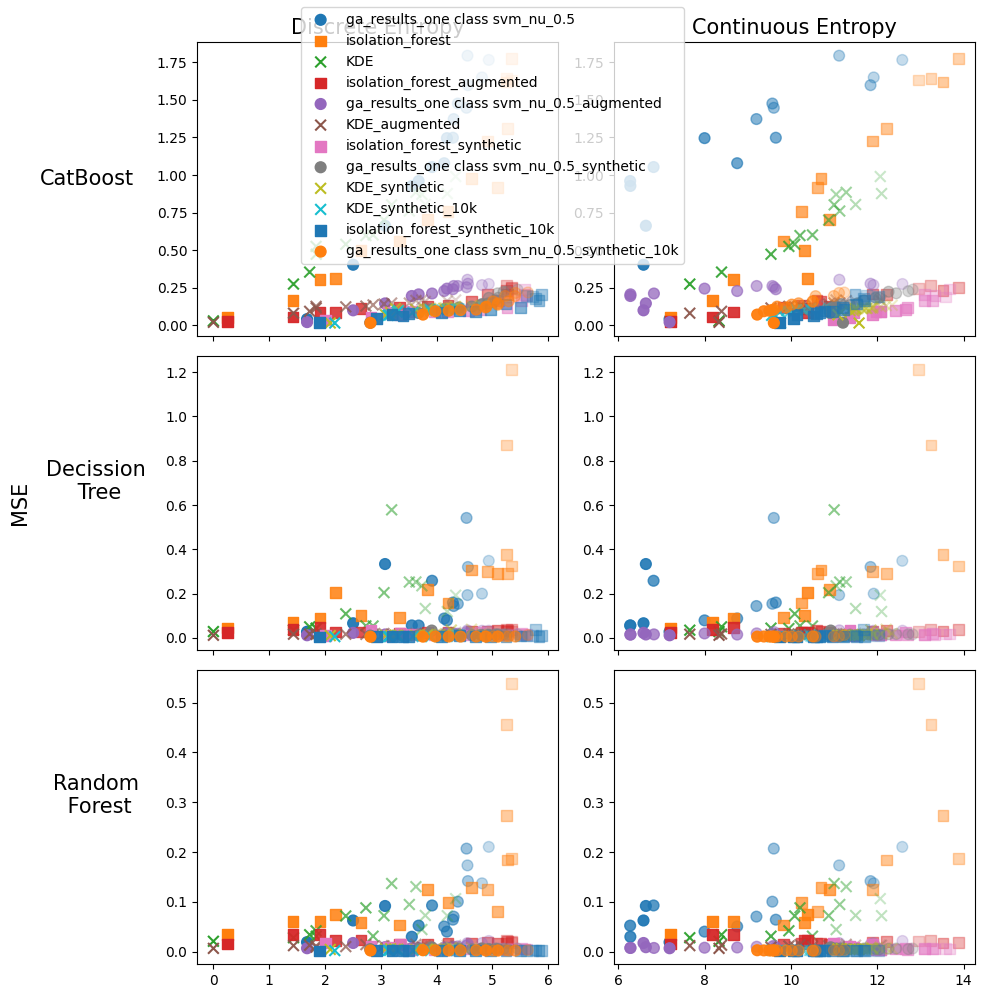

In [62]:
from matplotlib.gridspec import GridSpec
from matplotlib import colors
fig, axes = plt.subplots(len(model_names), len(keysm), figsize=(10, 10), sharex='col')
gs = GridSpec(len(model_names) + 1, len(keysm), figure=fig, width_ratios=[15, 1]) # Adjust width ratio as needed
cols = []
NO_PLAUS = False
times = np.zeros((len(model_names), len(keysm)))
for me in range(len(keysm)):
    cols.append(better_names[keysm[me]])
for axx, col in zip(axes[0], cols):
    axx.set_title(col, fontsize=15)
color = 0
for ke, va in outputs.items():
    ga_name = ke
    average_list = va['average_list']
    std_list = va['std_list']
    metrics_final = va['metrics_final']
    model_performances = []
    metric_performances = []
    for i, model_name in enumerate(model_names):
        avgl = np.array([a[i][0][0] for a in average_list])
        stdl = np.array([s[i][0][0] for s in std_list])
        model_performances.append(avgl)
    for i, met in enumerate(keysm):
        avgm = np.array(metrics_final[met][0])
        metric_performances.append(avgm)
    c='C{}'.format(color)
    alpha_max = 1.0  # Maximum alpha value
    alpha_min = 0.2  # Minimum alpha value
    alpha_range = alpha_max - alpha_min
    total_points = len(avgl)
    alphas = [alpha_max - (i / (total_points - 1)) * alpha_range for i in range(total_points)]

    for model_c in range(len(model_performances)):
        for metric_c in range(len(metric_performances)):
            plaus_mep = metric_performances[metric_c][:-1]
            plaus_mop = model_performances[model_c][:-1]
            no_plaus_mep = metric_performances[0][-1]
            no_plaus_mop = model_performances[0][-1]
            ax = axes[model_c, metric_c]
            # if not model_c:
            #     axes[model_c][0].set_title(cols[0]+better_names[model_names[model_c]], fontsize=12)
            # else:
            #     axes[model_c][0].set_title(better_names[model_names[model_c]], fontsize=12)
            sc = ax.scatter(plaus_mep, plaus_mop, label=ga_name, c=c, alpha=alphas, s=60, marker=markers[ga_name])
            # ax.set_ylabel("MSE " + better_names[model_names[model_c]])
            # if model_c == 1:
            #     # axes[model_c][0].set_ylabel(metric_names[0], fontsize=15)
            #     axes[model_c][0].set_ylabel(better_names[model_names[model_c]], rotation=0, fontsize=15)
            axes[model_c][0].set_ylabel(better_names[model_names[model_c]], rotation=0, fontsize=15, labelpad=50)
            
            if NO_PLAUS and not times[model_c, metric_c]:
                ax.scatter(no_plaus_mep, no_plaus_mop, label="None", color="black", alpha=0.5)
                times[model_c, metric_c] = 1
    # annotations = ['Z0', 'Z1', 'Z2', 'Z3', 'inf']
    # for i, (x, y) in enumerate(zip(plaus_mep, plaus_mop)):
    #     ax.annotate(annotations[i], (x, y), ha='center', fontsize=5)

    color += 1
    handles, labels = ax.get_legend_handles_labels()

# Dummy scatter plot with black color (no actual points)
# sc = ax.scatter([], [], c='black', alpha=alphas, s=60, label='Dummy')

# sc = ax.scatter(x, y, c=x, cmap=custom_cmap)

# Add colorbar on the right
# custom_cmap = create_colormap(alpha_min, alpha_max)
# sm = ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=alpha_min, vmax=alpha_max))
# cbar = fig.colorbar(sm, ax=axes[-1, :], pad=0.1, aspect=10, location='bottom')
# cbar.set_label('Plausibility threshold')

# Create a color bar for the alphas values
# cbar = plt.colorbar(sc, ax=ax, c="black", orientation='vertical', pad=0.1)
# cbar.set_label('Alphas')  # You can customize the label

fig.legend(handles, labels, loc='upper center')
fig.supylabel(metric_names[0], fontsize=15)
# plt.xticks(metric_performances[metric_c], thr_labels, size='small')
plt.tight_layout()
plt.show()


[<Axes: > <Axes: >]
[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.6499999999999999, 0.6, 0.55, 0.5, 0.44999999999999996, 0.3999999999999999, 0.35, 0.29999999999999993, 0.25, 0.19999999999999996]


/tmp/ipykernel_11798/456091102.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


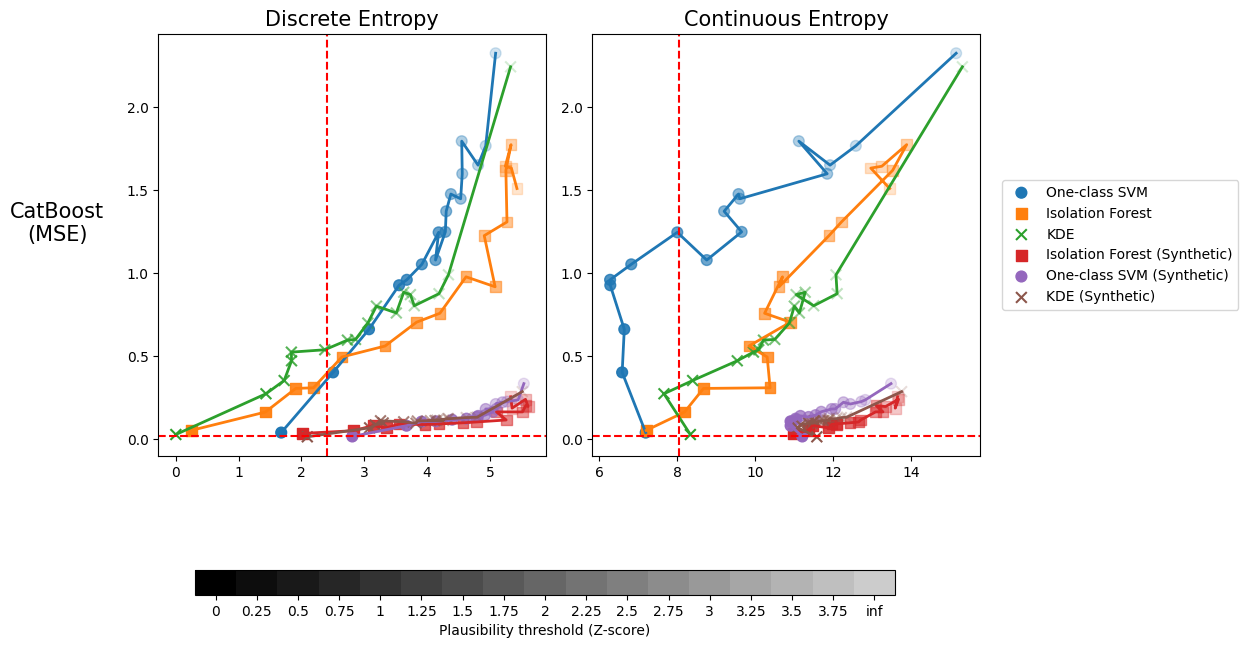

In [63]:
from matplotlib.gridspec import GridSpec
from matplotlib import colors

with open("entropy_real.json") as f:
    real_entropy = json.load(f)

with open("../synthetic_data_quantity_experiment/number_of_instances_100.json") as f:
    real_ml_perf = json.load(f)

model_names = ["CBR"]
fig, axes = plt.subplots(len(model_names), len(keysm), figsize=(10, 5), sharex='col')
print(axes)
gs = GridSpec(len(model_names) + 1, len(keysm), figure=fig, width_ratios=[15, 1]) # Adjust width ratio as needed
cols = []
NO_PLAUS = False
ERROR_BARS = False
AUGMENTED = False
SYNTHETIC = True
OTHER = True
TENK = False

times = np.zeros((len(model_names), len(keysm)))
for me in range(len(keysm)):
    cols.append(better_names[keysm[me]])
for axx, col in zip(axes, cols):
    axx.set_title(col, fontsize=15)
color = 0
for ke, va in outputs.items():
    ga_name = ke
    if not AUGMENTED and "augmented" in ga_name.lower():
        continue
    if not SYNTHETIC and "synthetic" in ga_name.lower():
        continue
    if not OTHER and "augmented" not in ga_name.lower() and "synthetic" not in ga_name.lower():
        continue
    if not TENK and "10k" in ga_name.lower():
        continue
    average_list = va['average_list']
    std_list = va['std_list']
    metrics_final = va['metrics_final']
    model_performances = []
    metric_performances = []
    metric_performances_std = []
    model_performances_std = []
    for i, model_name in enumerate(model_names):
        avgl = np.array([a[i][0][0] for a in average_list])
        stdl = np.array([s[i][0][0] for s in std_list])
        model_performances.append(avgl)
        model_performances_std.append(stdl)
    for i, met in enumerate(keysm):
        avgm = np.array(metrics_final[met][0])
        stdm = np.array(metrics_final[met][1])
        metric_performances.append(avgm)
        metric_performances_std.append(stdm)
    c='C{}'.format(color)
    alpha_max = 1.0  # Maximum alpha value
    alpha_min = 0.2  # Minimum alpha value
    alpha_range = alpha_max - alpha_min
    total_points = len(z_scores)
    alphas = [alpha_max - (i / (total_points - 1)) * alpha_range for i in range(total_points)]



    for model_c in range(len(model_performances)):
        for metric_c in range(len(metric_performances)):
            plaus_mep = metric_performances[metric_c]
            plaus_mop = model_performances[model_c]

            plaus_mep_std = metric_performances_std[metric_c]
            plaus_mop_std = model_performances_std[model_c]
            ax = axes[metric_c]
            # if not model_c:
            #     axes[model_c][0].set_title(cols[0]+better_names[model_names[model_c]], fontsize=12)
            # else:
            #     axes[model_c][0].set_title(better_names[model_names[model_c]], fontsize=12)
            sc = ax.scatter(plaus_mep, plaus_mop, label=better_names[ga_name], c=c, alpha=alphas, s=60, marker=markers[ga_name])
            ax.plot(plaus_mep, plaus_mop, color=c, linestyle='-', linewidth=2)
            if ERROR_BARS:
                ax.errorbar(plaus_mep, plaus_mop, xerr=plaus_mep_std, yerr=plaus_mop_std, color="black", alpha=0.2)
            # ax.set_ylabel("MSE " + better_names[model_names[model_c]])
            # if model_c == 1:
            #     # axes[model_c][0].set_ylabel(metric_names[0], fontsize=15)
            #     axes[model_c][0].set_ylabel(better_names[model_names[model_c]], rotation=0, fontsize=15)
            axes[model_c].set_ylabel(better_names[model_names[model_c]]+"\n({})".format(metric_names[0]), rotation=0, fontsize=15, labelpad=50)
            
            if NO_PLAUS and not times[model_c, metric_c]:
                ax.scatter(no_plaus_mep, no_plaus_mop, label="None", color="black", alpha=0.5)
                times[model_c, metric_c] = 1
    # annotations = ['Z0', 'Z1', 'Z2', 'Z3', 'inf']
    # for i, (x, y) in enumerate(zip(plaus_mep, plaus_mop)):
    #     ax.annotate(annotations[i], (x, y), ha='center', fontsize=5)

    color += 1
    handles, labels = ax.get_legend_handles_labels()

# print(metric_performances[metric_c])
# print(thr_str)
# Dummy scatter plot with black color (no actual points)
# sc = ax.scatter([], [], c='black', alpha=alphas, s=60, label='Dummy')

# sc = ax.scatter(x, y, c=x, cmap=custom_cmap)
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as ticker
# Add colorbar on the right

custom_cmap = create_colormap(alpha_max, alpha_min, np.flip(alphas))
sm = ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=alpha_min, vmax=alpha_max))
cbar_ax = fig.add_axes([0.2, -0.2, 0.7, 0.05])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label('Plausibility threshold (Z-score)')

# Calculate bin centers
stepp = alphas[0] - alphas[1]
print(alphas)
# bin_centers = np.linspace(alpha_min, alpha_max, len(z_scores))
bin_centers_mid = np.arange(alpha_min + stepp, alpha_max-stepp, stepp)
# # bin_centers = np.linspace(0, 1.1, len(z_scores)-1)
# # bin_centers = np.arange(0, len(z_scores))
# print(bin_centers)


# bin_centers = np.linspace(alpha_min + stepp/2, alpha_max-stepp/2, len(z_scores))

# cbar.ax.locator_params(nbins=len(z_scores))
cbar.ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=2*len(alphas)+1))

xticks = cbar.ax.get_xticks()[1::2]


stepp = 1/len(alphas)
cbar.ax.xaxis.set_major_locator(ticker.FixedLocator(xticks))
cbar.ax.set_xticklabels(z_scores)
# Create a color bar for the alphas values
# cbar = plt.colorbar(sc, ax=ax, c="black", orientation='vertical', pad=0.1)
# cbar.set_label('Alphas')  # You can customize the label


for i in range(len(real_entropy)):
    axes[i].axvline(x=real_entropy[keysm[i]], color='r', linestyle='--', label='real entropy')

    axes[i].axhline(y=real_ml_perf['100'][model_names[0]][metric_names[0]]["real"]["average"], color='r', linestyle='--', label='real ')



fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
# fig.supylabel(metric_names[0], fontsize=15)
# plt.xticks(metric_performances[metric_c], thr_labels, size='small')
plt.tight_layout()
plt.show()


[[<Axes: > <Axes: >]
 [<Axes: > <Axes: >]
 [<Axes: > <Axes: >]]
[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.6499999999999999, 0.6, 0.55, 0.5, 0.44999999999999996, 0.3999999999999999, 0.35, 0.29999999999999993, 0.25, 0.19999999999999996]
[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.6499999999999999, 0.6, 0.55, 0.5, 0.44999999999999996, 0.3999999999999999, 0.35, 0.29999999999999993, 0.25, 0.19999999999999996]
[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.6499999999999999, 0.6, 0.55, 0.5, 0.44999999999999996, 0.3999999999999999, 0.35, 0.29999999999999993, 0.25, 0.19999999999999996]


/tmp/ipykernel_11798/4243442264.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


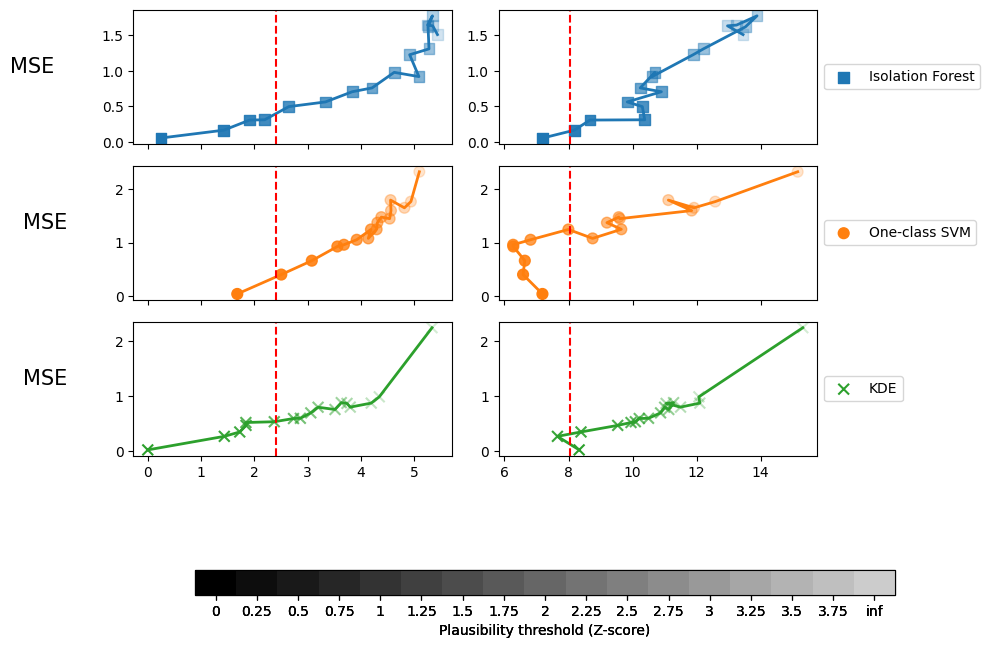

In [64]:
from matplotlib.gridspec import GridSpec
from matplotlib import colors

with open("entropy_real.json") as f:
    real_entropy = json.load(f)

with open("../synthetic_data_quantity_experiment/number_of_instances_100.json") as f:
    real_ml_perf = json.load(f)


method_names = ["isolation_forest", "svm", "kde"]

model_names = ["CBR"]
fig, axes = plt.subplots(len(method_names), len(keysm), figsize=(10, 5), sharex='col')
print(axes)
gs = GridSpec(len(method_names) + 1, len(keysm), figure=fig, width_ratios=[15, 1]) # Adjust width ratio as needed
cols = []
NO_PLAUS = False
ERROR_BARS = False
AUGMENTED = False
SYNTHETIC = False
OTHER = True
TENK = False

times = np.zeros((len(model_names), len(keysm)))
for me in range(len(keysm)):
    cols.append(better_names[keysm[me]])
# for axx, col in zip(axes, cols):
#     axx.set_title(col, fontsize=15)
color = 0

for ii, method_name in enumerate(method_names):
    for ke, va in outputs.items():
        ga_name = ke
        if not AUGMENTED and "augmented" in ga_name.lower():
            continue
        if not SYNTHETIC and "synthetic" in ga_name.lower():
            continue
        if not OTHER and "augmented" not in ga_name.lower() and "synthetic" not in ga_name.lower():
            continue
        if not TENK and "10k" in ga_name.lower():
            continue
        if method_name not in ga_name.lower():
            continue
        average_list = va['average_list']
        std_list = va['std_list']
        metrics_final = va['metrics_final']
        model_performances = []
        metric_performances = []
        metric_performances_std = []
        model_performances_std = []
        for i, model_name in enumerate(model_names):
            avgl = np.array([a[i][0][0] for a in average_list])
            stdl = np.array([s[i][0][0] for s in std_list])
            model_performances.append(avgl)
            model_performances_std.append(stdl)
        for i, met in enumerate(keysm):
            avgm = np.array(metrics_final[met][0])
            stdm = np.array(metrics_final[met][1])
            metric_performances.append(avgm)
            metric_performances_std.append(stdm)
        c='C{}'.format(color)
        alpha_max = 1.0  # Maximum alpha value
        alpha_min = 0.2  # Minimum alpha value
        alpha_range = alpha_max - alpha_min
        total_points = len(z_scores)
        alphas = [alpha_max - (i / (total_points - 1)) * alpha_range for i in range(total_points)]



        for model_c in range(len(model_performances)):
            for metric_c in range(len(metric_performances)):
                plaus_mep = metric_performances[metric_c]
                plaus_mop = model_performances[model_c]

                plaus_mep_std = metric_performances_std[metric_c]
                plaus_mop_std = model_performances_std[model_c]
                ax = axes[ii][metric_c]
                # if not model_c:
                #     axes[model_c][0].set_title(cols[0]+better_names[model_names[model_c]], fontsize=12)
                # else:
                #     axes[model_c][0].set_title(better_names[model_names[model_c]], fontsize=12)
                sc = ax.scatter(plaus_mep, plaus_mop, label=better_names[ga_name], c=c, alpha=alphas, s=60, marker=markers[ga_name])
                ax.plot(plaus_mep, plaus_mop, color=c, linestyle='-', linewidth=2)
                if ERROR_BARS:
                    ax.errorbar(plaus_mep, plaus_mop, xerr=plaus_mep_std, yerr=plaus_mop_std, color="black", alpha=0.2)
                # ax.set_ylabel("MSE " + better_names[model_names[model_c]])
                # if model_c == 1:
                #     # axes[model_c][0].set_ylabel(metric_names[0], fontsize=15)
                #     axes[model_c][0].set_ylabel(better_names[model_names[model_c]], rotation=0, fontsize=15)
                axes[ii][model_c].set_ylabel(metric_names[0], rotation=0, fontsize=15, labelpad=50)
                
                if NO_PLAUS and not times[model_c, metric_c]:
                    ax[ii].scatter(no_plaus_mep, no_plaus_mop, label="None", color="black", alpha=0.5)
                    times[model_c, metric_c] = 1
        # annotations = ['Z0', 'Z1', 'Z2', 'Z3', 'inf']
        # for i, (x, y) in enumerate(zip(plaus_mep, plaus_mop)):
        #     ax.annotate(annotations[i], (x, y), ha='center', fontsize=5)

        color += 1
        handles, labels = ax.get_legend_handles_labels()

    # print(metric_performances[metric_c])
    # print(thr_str)
    # Dummy scatter plot with black color (no actual points)
    # sc = ax.scatter([], [], c='black', alpha=alphas, s=60, label='Dummy')

    # sc = ax.scatter(x, y, c=x, cmap=custom_cmap)
    from matplotlib.cm import ScalarMappable
    import matplotlib.ticker as ticker
    # Add colorbar on the right

    custom_cmap = create_colormap(alpha_max, alpha_min, np.flip(alphas))
    sm = ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=alpha_min, vmax=alpha_max))
    cbar_ax = fig.add_axes([0.2, -0.2, 0.7, 0.05])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
    cbar.set_label('Plausibility threshold (Z-score)')

    # Calculate bin centers
    stepp = alphas[0] - alphas[1]
    print(alphas)
    # bin_centers = np.linspace(alpha_min, alpha_max, len(z_scores))
    bin_centers_mid = np.arange(alpha_min + stepp, alpha_max-stepp, stepp)
    # # bin_centers = np.linspace(0, 1.1, len(z_scores)-1)
    # # bin_centers = np.arange(0, len(z_scores))
    # print(bin_centers)


    # bin_centers = np.linspace(alpha_min + stepp/2, alpha_max-stepp/2, len(z_scores))

    # cbar.ax.locator_params(nbins=len(z_scores))
    cbar.ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=2*len(alphas)+1))

    xticks = cbar.ax.get_xticks()[1::2]


    stepp = 1/len(alphas)
    cbar.ax.xaxis.set_major_locator(ticker.FixedLocator(xticks))
    cbar.ax.set_xticklabels(z_scores)
    # Create a color bar for the alphas values
    # cbar = plt.colorbar(sc, ax=ax, c="black", orientation='vertical', pad=0.1)
    # cbar.set_label('Alphas')  # You can customize the label


    for i in range(len(real_entropy)):
        axes[ii][i].axvline(x=real_entropy[keysm[i]], color='r', linestyle='--', label='real entropy')

        # axes[ii][i].axhline(y=real_ml_perf['100'][model_names[0]][metric_names[0]]["real"]["average"], color='r', linestyle='--', label='real ')



    axes[ii][i].legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
# fig.supylabel(metric_names[0], fontsize=15)
# plt.xticks(metric_performances[metric_c], thr_labels, size='small')
plt.tight_layout()
plt.show()


[<Axes: > <Axes: >]
C0 One-class SVM
C0 One-class SVM
C1 Isolation Forest
C1 Isolation Forest
C2 KDE
C2 KDE
C0 Isolation Forest (Synthetic)
C0 Isolation Forest (Synthetic)
C1 One-class SVM (Synthetic)
C1 One-class SVM (Synthetic)
C2 KDE (Synthetic)
C2 KDE (Synthetic)
[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.6499999999999999, 0.6, 0.55, 0.5, 0.44999999999999996, 0.3999999999999999, 0.35, 0.29999999999999993, 0.25, 0.19999999999999996]


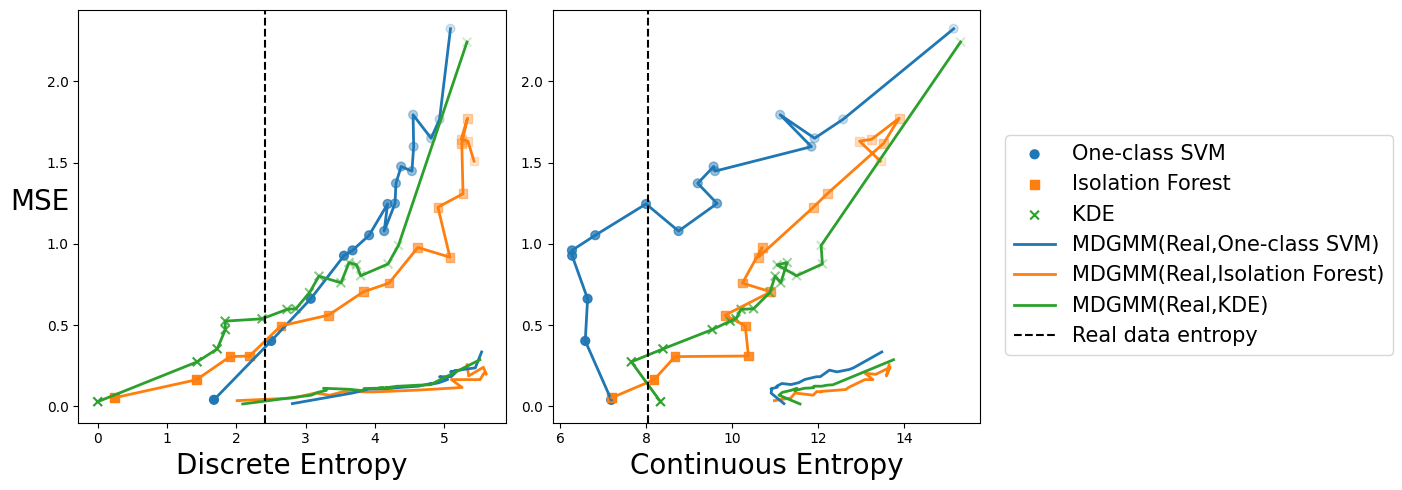

In [65]:
from matplotlib.gridspec import GridSpec
from matplotlib import colors

with open("entropy_real.json") as f:
    real_entropy = json.load(f)

with open("../synthetic_data_quantity_experiment/number_of_instances_100.json") as f:
    real_ml_perf = json.load(f)

model_names = ["CBR"]
fig, axes = plt.subplots(len(model_names), len(keysm), figsize=(10, 5), sharex='col')
print(axes)
gs = GridSpec(len(model_names) + 1, len(keysm), figure=fig, width_ratios=[15, 1]) # Adjust width ratio as needed
cols = []
NO_PLAUS = False
ERROR_BARS = False
AUGMENTED = False
SYNTHETIC = True
OTHER = True
TENK = False
color_maps = {}
fontsize=20
times = np.zeros((len(model_names), len(keysm)))
for me in range(len(keysm)):
    cols.append(better_names[keysm[me]])
for axx, col in zip(axes, cols):
    axx.set_xlabel(col, fontsize=fontsize)
color = 0
for ke, va in outputs.items():
    ga_name = ke
    if not AUGMENTED and "augmented" in ga_name.lower():
        continue
    if not SYNTHETIC and "synthetic" in ga_name.lower():
        continue
    if not OTHER and "augmented" not in ga_name.lower() and "synthetic" not in ga_name.lower():
        continue
    if not TENK and "10k" in ga_name.lower():
        continue
    average_list = va['average_list']
    std_list = va['std_list']
    metrics_final = va['metrics_final']
    model_performances = []
    metric_performances = []
    metric_performances_std = []
    model_performances_std = []
    for i, model_name in enumerate(model_names):
        avgl = np.array([a[i][0][0] for a in average_list])
        stdl = np.array([s[i][0][0] for s in std_list])
        model_performances.append(avgl)
        model_performances_std.append(stdl)
    for i, met in enumerate(keysm):
        avgm = np.array(metrics_final[met][0])
        stdm = np.array(metrics_final[met][1])
        metric_performances.append(avgm)
        metric_performances_std.append(stdm)
    alpha_max = 1.0  # Maximum alpha value
    alpha_min = 0.2  # Minimum alpha value
    alpha_range = alpha_max - alpha_min
    total_points = len(z_scores)
    alphas = [alpha_max - (i / (total_points - 1)) * alpha_range for i in range(total_points)]



    for model_c in range(len(model_performances)):
        for metric_c in range(len(metric_performances)):
            plaus_mep = metric_performances[metric_c]
            plaus_mop = model_performances[model_c]

            plaus_mep_std = metric_performances_std[metric_c]
            plaus_mop_std = model_performances_std[model_c]
            ax = axes[metric_c]
            # if not model_c:
            #     axes[model_c][0].set_title(cols[0]+better_names[model_names[model_c]], fontsize=12)
            # else:
            #     axes[model_c][0].set_title(better_names[model_names[model_c]], fontsize=12)
            if "synthetic" not in ga_name.lower():
                c='C{}'.format(color)
                sc = ax.scatter(plaus_mep, plaus_mop, label=better_names[ga_name], c=c, alpha=alphas, s=40, marker=markers[ga_name])
                ax.plot(plaus_mep, plaus_mop, color=c, linestyle='-', linewidth=2)
                print(c, better_names[ga_name])
                color_maps[better_names[ga_name]] = c
            else:
                c='C{}'.format(color % 3)
                frmt = better_names[ga_name].split(" (")[0]
                ax.plot(plaus_mep, plaus_mop, color=color_maps[frmt], linestyle='-', linewidth=2, label="MDGMM(Real,{})".format(frmt))
                print(c, better_names[ga_name])

            if ERROR_BARS:
                ax.errorbar(plaus_mep, plaus_mop, xerr=plaus_mep_std, yerr=plaus_mop_std, color="black", alpha=0.2)
            # ax.set_ylabel("MSE " + better_names[model_names[model_c]])
            # if model_c == 1:
            #     # axes[model_c][0].set_ylabel(metric_names[0], fontsize=15)
            #     axes[model_c][0].set_ylabel(better_names[model_names[model_c]], rotation=0, fontsize=15)
            axes[model_c].set_ylabel(metric_names[0], rotation=0, fontsize=fontsize, labelpad=5)
            
            if NO_PLAUS and not times[model_c, metric_c]:
                ax.scatter(no_plaus_mep, no_plaus_mop, label="None", color="black", alpha=0.5)
                times[model_c, metric_c] = 1
    # annotations = ['Z0', 'Z1', 'Z2', 'Z3', 'inf']
    # for i, (x, y) in enumerate(zip(plaus_mep, plaus_mop)):
    #     ax.annotate(annotations[i], (x, y), ha='center', fontsize=5)
    color += 1
    handles, labels = ax.get_legend_handles_labels()

# print(metric_performances[metric_c])
# print(thr_str)
# Dummy scatter plot with black color (no actual points)
# sc = ax.scatter([], [], c='black', alpha=alphas, s=60, label='Dummy')

# sc = ax.scatter(x, y, c=x, cmap=custom_cmap)
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as ticker
# Add colorbar on the right

custom_cmap = create_colormap(alpha_max, alpha_min, np.flip(alphas))
# sm = ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=alpha_min, vmax=alpha_max))
# cbar_ax = fig.add_axes([0.2, -0.2, 0.7, 0.05])
# cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
# cbar.set_label('Plausibility threshold (Z-score)')

# Calculate bin centers
stepp = alphas[0] - alphas[1]
print(alphas)
# bin_centers = np.linspace(alpha_min, alpha_max, len(z_scores))
bin_centers_mid = np.arange(alpha_min + stepp, alpha_max-stepp, stepp)
# # bin_centers = np.linspace(0, 1.1, len(z_scores)-1)
# # bin_centers = np.arange(0, len(z_scores))
# print(bin_centers)


# bin_centers = np.linspace(alpha_min + stepp/2, alpha_max-stepp/2, len(z_scores))

# cbar.ax.locator_params(nbins=len(z_scores))
# cbar.ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=2*len(alphas)+1))

# xticks = cbar.ax.get_xticks()[1::2]


# stepp = 1/len(alphas)
# cbar.ax.xaxis.set_major_locator(ticker.FixedLocator(xticks))
# cbar.ax.set_xticklabels(z_scores)
# Create a color bar for the alphas values
# cbar = plt.colorbar(sc, ax=ax, c="black", orientation='vertical', pad=0.1)
# cbar.set_label('Alphas')  # You can customize the label


for i in range(len(real_entropy)):
    # axes[i].axvline(x=real_entropy[keysm[i]], color='black', linestyle='--', label='real entropy', ymin=0, ymax=0.7)
    # axes[i].annotate("Real entropy", xy=(real_entropy[keysm[i]], 2), xytext=(real_entropy[keysm[i]], 2), fontsize=20, ha='center', va='center')       


    axes[i].axvline(x=real_entropy[keysm[i]], color='black', linestyle='--', label='Real data entropy')
 
    r_handles, r_labels = axes[i].get_legend_handles_labels()
    # axes[i].axhline(y=real_ml_perf['100'][model_names[0]][metric_names[0]]["real"]["average"], color='r', linestyle='--', label='real ')

labels_new = ['One-class SVM', 'Isolation Forest', 'KDE', 'MDGMM(Real,One-class SVM)', 'MDGMM(Real,Isolation Forest)', 'MDGMM(Real,KDE)']
# Create a dictionary to map labels to handles
label_handle_dict = dict(zip(labels, handles))

# Create a new list of handles in the order of labels_new
handles_new_order = [label_handle_dict[label] for label in labels_new]
fig.legend(handles_new_order + [r_handles[-1]], labels_new + [r_labels[-1]], loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fontsize-5)
# fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# fig.supylabel(metric_names[0], fontsize=15)
# plt.xticks(metric_performances[metric_c], thr_labels, size='small')
plt.tight_layout()
# plt.savefig("ga_eval.png", dpi=300, bbox_inches="tight")

plt.show()


[<Axes: > <Axes: >]
C0 One-class SVM
C0 One-class SVM
C1 Isolation Forest
C1 Isolation Forest
C2 KDE
C2 KDE
[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.6499999999999999, 0.6, 0.55, 0.5, 0.44999999999999996, 0.3999999999999999, 0.35, 0.29999999999999993, 0.25, 0.19999999999999996]


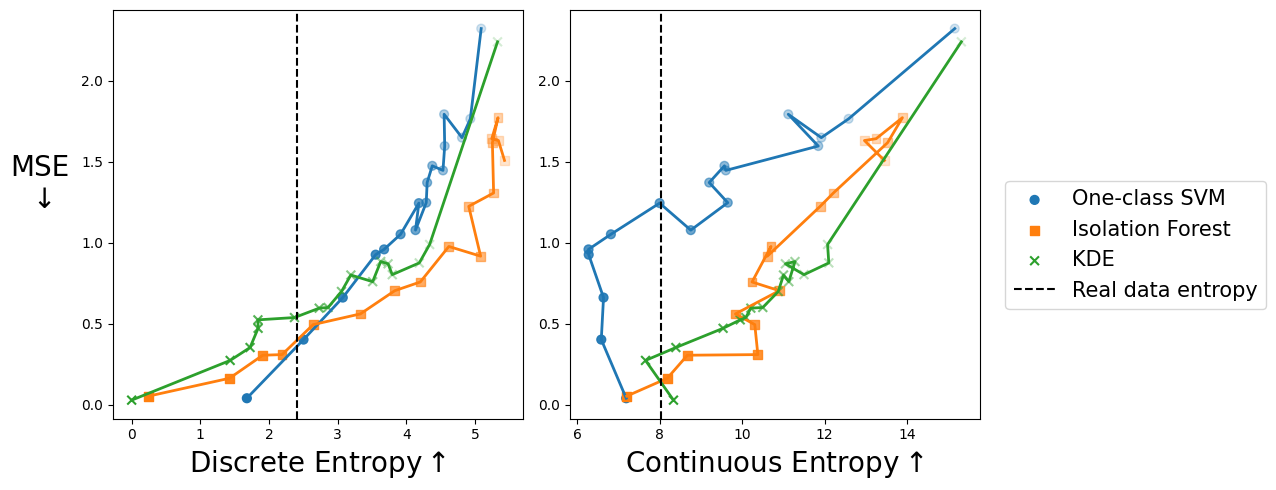

In [66]:
from matplotlib.gridspec import GridSpec
from matplotlib import colors

with open("entropy_real.json") as f:
    real_entropy = json.load(f)

with open("../synthetic_data_quantity_experiment/number_of_instances_100.json") as f:
    real_ml_perf = json.load(f)

metric_names = ["MSE\n"+ r"$\downarrow$"]

model_names = ["CBR"]
fig, axes = plt.subplots(len(model_names), len(keysm), figsize=(10, 5), sharex='col')
print(axes)
gs = GridSpec(len(model_names) + 1, len(keysm), figure=fig, width_ratios=[15, 1]) # Adjust width ratio as needed
cols = []
NO_PLAUS = False
ERROR_BARS = False
AUGMENTED = False
SYNTHETIC = False
OTHER = True
TENK = False
color_maps = {}
fontsize=20
times = np.zeros((len(model_names), len(keysm)))
for me in range(len(keysm)):
    cols.append(better_names[keysm[me]] + r"$\uparrow$")
for axx, col in zip(axes, cols):
    axx.set_xlabel(col, fontsize=fontsize)
color = 0
for ke, va in outputs.items():
    ga_name = ke
    if not AUGMENTED and "augmented" in ga_name.lower():
        continue
    if not SYNTHETIC and "synthetic" in ga_name.lower():
        continue
    if not OTHER and "augmented" not in ga_name.lower() and "synthetic" not in ga_name.lower():
        continue
    if not TENK and "10k" in ga_name.lower():
        continue
    average_list = va['average_list']
    std_list = va['std_list']
    metrics_final = va['metrics_final']
    model_performances = []
    metric_performances = []
    metric_performances_std = []
    model_performances_std = []
    for i, model_name in enumerate(model_names):
        avgl = np.array([a[i][0][0] for a in average_list])
        stdl = np.array([s[i][0][0] for s in std_list])
        model_performances.append(avgl)
        model_performances_std.append(stdl)
    for i, met in enumerate(keysm):
        avgm = np.array(metrics_final[met][0])
        stdm = np.array(metrics_final[met][1])
        metric_performances.append(avgm)
        metric_performances_std.append(stdm)
    alpha_max = 1.0  # Maximum alpha value
    alpha_min = 0.2  # Minimum alpha value
    alpha_range = alpha_max - alpha_min
    total_points = len(z_scores)
    alphas = [alpha_max - (i / (total_points - 1)) * alpha_range for i in range(total_points)]



    for model_c in range(len(model_performances)):
        for metric_c in range(len(metric_performances)):
            plaus_mep = metric_performances[metric_c]
            plaus_mop = model_performances[model_c]

            plaus_mep_std = metric_performances_std[metric_c]
            plaus_mop_std = model_performances_std[model_c]
            ax = axes[metric_c]
            # if not model_c:
            #     axes[model_c][0].set_title(cols[0]+better_names[model_names[model_c]], fontsize=12)
            # else:
            #     axes[model_c][0].set_title(better_names[model_names[model_c]], fontsize=12)
            if "synthetic" not in ga_name.lower():
                c='C{}'.format(color)
                sc = ax.scatter(plaus_mep, plaus_mop, label=better_names[ga_name], c=c, alpha=alphas, s=40, marker=markers[ga_name])
                ax.plot(plaus_mep, plaus_mop, color=c, linestyle='-', linewidth=2)
                print(c, better_names[ga_name])
                color_maps[better_names[ga_name]] = c
            else:
                c='C{}'.format(color % 3)
                frmt = better_names[ga_name].split(" (")[0]
                ax.plot(plaus_mep, plaus_mop, color=color_maps[frmt], linestyle='-', linewidth=2, label="MDGMM(Real,{})".format(frmt))
                print(c, better_names[ga_name])

            if ERROR_BARS:
                ax.errorbar(plaus_mep, plaus_mop, xerr=plaus_mep_std, yerr=plaus_mop_std, color="black", alpha=0.2)
            # ax.set_ylabel("MSE " + better_names[model_names[model_c]])
            # if model_c == 1:
            #     # axes[model_c][0].set_ylabel(metric_names[0], fontsize=15)
            #     axes[model_c][0].set_ylabel(better_names[model_names[model_c]], rotation=0, fontsize=15)
            axes[model_c].set_ylabel(metric_names[0], rotation=0, fontsize=fontsize, labelpad=30)
            
            if NO_PLAUS and not times[model_c, metric_c]:
                ax.scatter(no_plaus_mep, no_plaus_mop, label="None", color="black", alpha=0.5)
                times[model_c, metric_c] = 1
    # annotations = ['Z0', 'Z1', 'Z2', 'Z3', 'inf']
    # for i, (x, y) in enumerate(zip(plaus_mep, plaus_mop)):
    #     ax.annotate(annotations[i], (x, y), ha='center', fontsize=5)
    color += 1
    handles, labels = ax.get_legend_handles_labels()

# print(metric_performances[metric_c])
# print(thr_str)
# Dummy scatter plot with black color (no actual points)
# sc = ax.scatter([], [], c='black', alpha=alphas, s=60, label='Dummy')

# sc = ax.scatter(x, y, c=x, cmap=custom_cmap)
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as ticker
# Add colorbar on the right

custom_cmap = create_colormap(alpha_max, alpha_min, np.flip(alphas))
# sm = ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=alpha_min, vmax=alpha_max))
# cbar_ax = fig.add_axes([0.2, -0.2, 0.7, 0.05])
# cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
# cbar.set_label('Plausibility threshold (Z-score)')

# Calculate bin centers
stepp = alphas[0] - alphas[1]
print(alphas)
# bin_centers = np.linspace(alpha_min, alpha_max, len(z_scores))
bin_centers_mid = np.arange(alpha_min + stepp, alpha_max-stepp, stepp)
# # bin_centers = np.linspace(0, 1.1, len(z_scores)-1)
# # bin_centers = np.arange(0, len(z_scores))
# print(bin_centers)


# bin_centers = np.linspace(alpha_min + stepp/2, alpha_max-stepp/2, len(z_scores))

# cbar.ax.locator_params(nbins=len(z_scores))
# cbar.ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=2*len(alphas)+1))

# xticks = cbar.ax.get_xticks()[1::2]


# stepp = 1/len(alphas)
# cbar.ax.xaxis.set_major_locator(ticker.FixedLocator(xticks))
# cbar.ax.set_xticklabels(z_scores)
# Create a color bar for the alphas values
# cbar = plt.colorbar(sc, ax=ax, c="black", orientation='vertical', pad=0.1)
# cbar.set_label('Alphas')  # You can customize the label


for i in range(len(real_entropy)):
    # axes[i].axvline(x=real_entropy[keysm[i]], color='black', linestyle='--', label='real entropy', ymin=0, ymax=0.7)
    # axes[i].annotate("Real entropy", xy=(real_entropy[keysm[i]], 2), xytext=(real_entropy[keysm[i]], 2), fontsize=20, ha='center', va='center')       


    axes[i].axvline(x=real_entropy[keysm[i]], color='black', linestyle='--', label='Real data entropy')
 
    r_handles, r_labels = axes[i].get_legend_handles_labels()
    # axes[i].axhline(y=real_ml_perf['100'][model_names[0]][metric_names[0]]["real"]["average"], color='r', linestyle='--', label='real ')

labels_new = ['One-class SVM', 'Isolation Forest', 'KDE']
# Create a dictionary to map labels to handles
label_handle_dict = dict(zip(labels, handles))

# Create a new list of handles in the order of labels_new
handles_new_order = [label_handle_dict[label] for label in labels_new]
fig.legend(handles_new_order + [r_handles[-1]], labels_new + [r_labels[-1]], loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fontsize-5)
# fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# fig.supylabel(metric_names[0], fontsize=15)
# plt.xticks(metric_performances[metric_c], thr_labels, size='small')
plt.tight_layout()
plt.savefig("ga_eval_no_synth.png", dpi=300, bbox_inches="tight")

plt.show()
